# Extension & Retracement Summary Statistics

Historical analysis of `breakside_retracement_normib`, `extension_up_normib`, and `extension_down_normib` grouped by:
- **Breakside** (high / low)
- **Rotation** (actual: True / False)

Statistics computed: mean, median, std dev, 10th percentile, 90th percentile

**Use case:** After mp3 predicts rotation and you observe breakside direction, look up the expected extension/retracement from these historical distributions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load phase2 data (use 10-min as default)
df = pd.read_csv("outputs/phase2_10min.csv")

# Target columns
METRICS = [
    "breakside_retracement_normib",
    "extension_up_normib",
    "extension_down_normib",
]

print(f"Total sessions: {len(df)}")
print(f"\nBreakside distribution:")
print(df["breakside"].value_counts())
print(f"\nRotation distribution:")
print(df["rotation"].value_counts())

Total sessions: 765

Breakside distribution:
breakside
high    383
low     360
none     22
Name: count, dtype: int64

Rotation distribution:
rotation
False    608
True     157
Name: count, dtype: int64


## 1. Summary Statistics by Breakside × Rotation

In [2]:
def compute_summary_stats(series):
    """Compute mean, median, std, 10th and 90th percentiles."""
    return pd.Series({
        "count": series.count(),
        "mean": series.mean(),
        "median": series.median(),
        "std": series.std(),
        "p10": series.quantile(0.10),
        "p90": series.quantile(0.90),
    })


# Filter to only high/low breakside (exclude 'none')
df_filtered = df[df["breakside"].isin(["high", "low"])].copy()
print(f"Sessions with high/low breakside: {len(df_filtered)}")

# Group by breakside and rotation
grouped = df_filtered.groupby(["breakside", "rotation"])

Sessions with high/low breakside: 743


In [3]:
# Build summary tables for each metric
summary_tables = {}

for metric in METRICS:
    stats = grouped[metric].apply(compute_summary_stats).unstack(level=-1)
    summary_tables[metric] = stats
    
    print(f"\n{'='*70}")
    print(f"  {metric}")
    print(f"{'='*70}")
    display(stats.round(4))


  breakside_retracement_normib


count    mean  median     std     p10     p90
breakside rotation                                               
high      False     314.0  0.3885  0.3324  0.2641  0.0829  0.7892
          True       69.0  1.9391  1.5539  1.2752  1.0802  2.8017
low       False     272.0  0.4490  0.4430  0.2595  0.1049  0.8161
          True       88.0  1.6768  1.3968  0.8635  1.0842  2.5220


  extension_up_normib


count    mean  median     std     p10     p90
breakside rotation                                               
high      False     314.0  0.7592  0.6216  0.6204  0.1538  1.5491
          True       69.0  0.4609  0.3329  0.4991  0.0835  0.8334
low       False     272.0  0.0000  0.0000  0.0000  0.0000  0.0000
          True       88.0  0.6768  0.3968  0.8635  0.0842  1.5220


  extension_down_normib


count    mean  median     std     p10     p90
breakside rotation                                               
high      False     314.0  0.0000  0.0000  0.0000  0.0000  0.0000
          True       69.0  0.9391  0.5539  1.2752  0.0802  1.8017
low       False     272.0  0.8653  0.6298  0.9275  0.1285  1.7514
          True       88.0  0.4605  0.3407  0.4067  0.0571  1.0004

## 2. Interpretation Guide

| Breakside | Rotation | What it means |
|-----------|----------|---------------|
| **high** | **False** | Price broke above IBH and did NOT return to touch IBL |
| **high** | **True** | Price broke above IBH AND returned to touch IBL (full rotation) |
| **low** | **False** | Price broke below IBL and did NOT return to touch IBH |
| **low** | **True** | Price broke below IBL AND returned to touch IBH (full rotation) |

**Metrics:**
- `breakside_retracement_normib`: How far price retraced back into IB range (normalized by IB range)
- `extension_up_normib`: How far price extended above IBH (normalized by IB range)
- `extension_down_normib`: How far price extended below IBL (normalized by IB range)

## 3. Visualizations

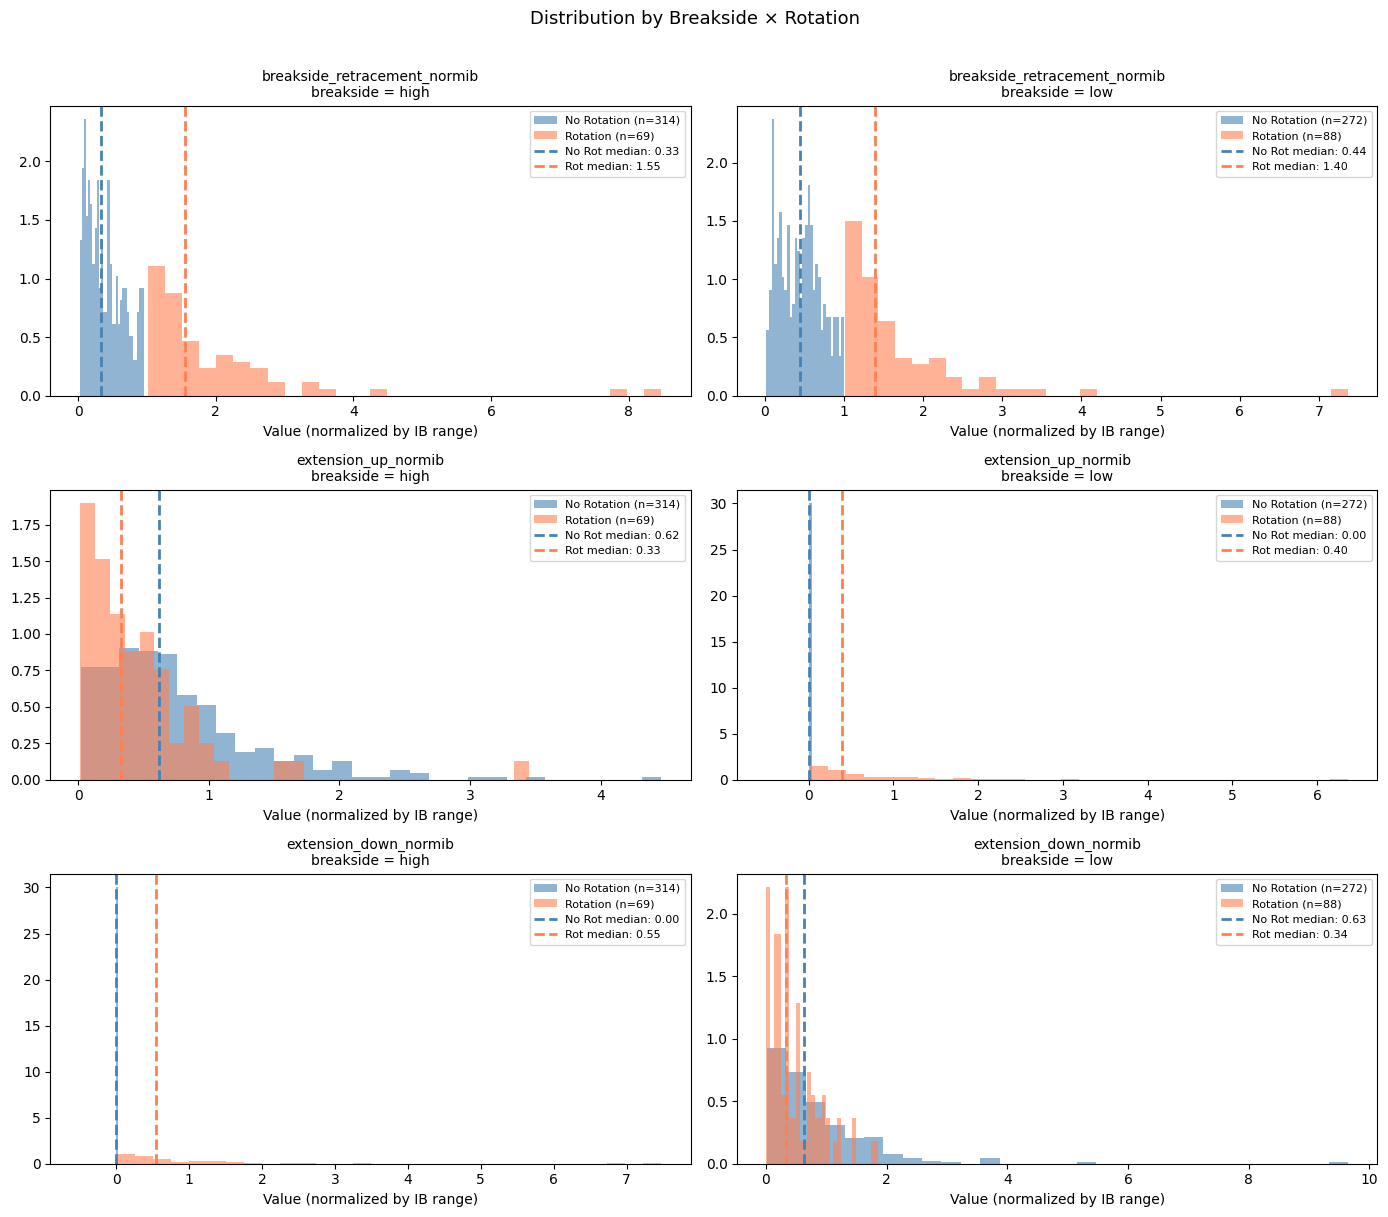

In [4]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for i, metric in enumerate(METRICS):
    for j, breakside in enumerate(["high", "low"]):
        ax = axes[i, j]
        subset = df_filtered[df_filtered["breakside"] == breakside]
        
        # Separate by rotation
        rot_true = subset[subset["rotation"] == True][metric].dropna()
        rot_false = subset[subset["rotation"] == False][metric].dropna()
        
        # Plot histograms
        ax.hist(rot_false, bins=30, alpha=0.6, label=f"No Rotation (n={len(rot_false)})", color="steelblue", density=True)
        ax.hist(rot_true, bins=30, alpha=0.6, label=f"Rotation (n={len(rot_true)})", color="coral", density=True)
        
        # Add median lines
        ax.axvline(rot_false.median(), color="steelblue", linestyle="--", linewidth=2, label=f"No Rot median: {rot_false.median():.2f}")
        ax.axvline(rot_true.median(), color="coral", linestyle="--", linewidth=2, label=f"Rot median: {rot_true.median():.2f}")
        
        ax.set_title(f"{metric}\nbreakside = {breakside}", fontsize=10)
        ax.set_xlabel("Value (normalized by IB range)")
        ax.legend(fontsize=8)

plt.suptitle("Distribution by Breakside × Rotation", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

## 4. Quick Lookup Table

Use this table after mp3 predicts rotation: given breakside direction and predicted rotation, look up expected extension/retracement.

In [5]:
# Build a compact lookup table with medians and p10/p90 ranges
lookup_rows = []

for breakside in ["high", "low"]:
    for rotation in [False, True]:
        subset = df_filtered[(df_filtered["breakside"] == breakside) & (df_filtered["rotation"] == rotation)]
        row = {
            "Breakside": breakside,
            "Rotation": "Yes" if rotation else "No",
            "N": len(subset),
        }
        for metric in METRICS:
            col_short = metric.replace("breakside_", "").replace("_normib", "")
            vals = subset[metric].dropna()
            row[f"{col_short}_median"] = f"{vals.median():.2f}"
            row[f"{col_short}_range"] = f"[{vals.quantile(0.1):.2f}, {vals.quantile(0.9):.2f}]"
        lookup_rows.append(row)

lookup_df = pd.DataFrame(lookup_rows)
print("Quick Lookup Table (median and [p10, p90] range):")
print("="*100)
display(lookup_df)

Quick Lookup Table (median and [p10, p90] range):


,Breakside,Rotation,N,retracement_median,retracement_range,extension_up_median,extension_up_range,extension_down_median,extension_down_range
0,high,No,314,0.33,"[0.08, 0.79]",0.62,"[0.15, 1.55]",0.00,"[0.00, 0.00]"
1,high,Yes,69,1.55,"[1.08, 2.80]",0.33,"[0.08, 0.83]",0.55,"[0.08, 1.80]"
2,low,No,272,0.44,"[0.10, 0.82]",0.00,"[0.00, 0.00]",0.63,"[0.13, 1.75]"
3,low,Yes,88,1.40,"[1.08, 2.52]",0.40,"[0.08, 1.52]",0.34,"[0.06, 1.00]"


## 5. Key Observations

Fill in after reviewing the results:

- **Rotation days vs non-rotation days:** Do rotation days show higher retracement? (expected)
- **Breakside high vs low:** Are extensions symmetric, or does one direction extend further?
- **Variance:** Which groups have tight vs wide distributions (low vs high std)?

### Using this for prediction

After mp3 gives you a rotation prediction:
1. Wait for breakside direction to establish (price breaks IBH or IBL)
2. Look up the expected extension from this table
3. Use p10/p90 as confidence bounds

**Example:** If mp3 predicts "No Rotation" and price breaks above IBH (breakside=high), look up:
- `extension_up_median` → expected upside extension
- `extension_down_median` → expected retracement (should be small for no-rotation days)